In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Gene2Vec Experiments
Attempting to recreate results of [gene2vec paper](https://doi.org/10.1186/s12864-018-5370-x)

1. [Import known gene pathways from MSigDB](#pathways)
2. [Generate pairs of genes from gene pathway sets](#pairs)
3. [Use `gensim` to train with gene2vec](#gensim)
4. [Visualise embeddings with PCA and tSNE](#vis)
5. [Load and preprocess somatic mutations from TCGA in BigQuery](#tcga)
6. [Produce 2D images for every sample](#2d)
7. [Model Training](#) 
    - 7.1 [Random Forest (baseline on sparse samples)](#)
    - 7.2 [XGBoost on images](#)
    - 7.3 [CNN (on images only)](#)
    - 7.4 [CNN w ImageNet weight initialisation (FastAI)](#)

#### 1. Import known gene pathways from [MSigDB](http://software.broadinstitute.org/gsea/msigdb/collections.jsp)
<a id="pathways"></a>

In [2]:
import pandas as pd
import gensim
import random

In [3]:
## word2vec parameters
dimension = 100     # dimension of the embedding
num_workers = 8     # number of worker threads
sg = 1              # sg =1, skip-gram, sg =0, CBOW
max_iter = 10       # number of iterations
window_size = 1     # The maximum distance between the gene and predicted gene within a gene list
negative = 3        # number of negative samples
txtOutput = True

# Environment variables
MSIGDB = '../data/gene2vec/msigdb.v6.2.symbols.gmt'
TCGA = '../data/gene2vec/processed_somatic_mutations_subset2'
INTOGEN = '../data/gene2vec/intogen-drivers-data.tsv'
GENE2VEC_DIR = '../experiments/gene2vec/models/'
FILENAME = 'gene2vec_dim_{0:d}_iter_'.format(dimension)

In [4]:
def _get_data(line):
    name, _, genes = line.split("\t", 2)
    return name, set(gene.replace('\n', '') for gene in genes.split("\t"))

with open(MSIGDB, 'r') as fp:
    pathways_df = pd.DataFrame(data=[_get_data(line) for line in fp],
                               columns=["name", "set"])

pathways_df.head()

,name,set
0,AAANWWTGC_UNKNOWN,"{GANAB, GRHL3, PHOX2B, PPP1R10, SPAG9, OLIG2, ..."
1,AAAYRNCTG_UNKNOWN,"{OMA1, UBE2W, PHOX2B, TRIM8, CRH, ZNF296, ZIC1..."
2,MYOD_01,"{GCNT3, MOSPD1, TAZ, CHD6, ARHGAP44, CKM, SOST..."
3,E47_01,"{MAP1A, GCNT3, IL23A, DUSP9, TAZ, CD47, TRIM8,..."
4,CMYB_01,"{RNF38, PRIC285, PHOX2B, SPAG9, DNAJB1, CDC14B..."


#### 2. Generate pairs of genes from gene pathway sets
<a id="pairs"></a>

In [5]:
pathways_subset = pathways_df.head(1000).copy()

In [6]:
def generate_gene_pairs(gene_set):
    from itertools import combinations
    # Get all combinations of length 2 
    pairs = combinations(list(gene_set), 2)
    return set(pairs)

def get_pairs_set(df):
    """
    Return the set union of all pairs from every gene set within the df.
    """
    return set.union(*df['pairs'].tolist())

pathways_subset['pairs'] = (pathways_subset.set
                                           .apply(generate_gene_pairs))

# total set of pairs without any duplication across samples
total_set = pathways_subset.pipe(get_pairs_set)

In [7]:
len(total_set)

31251852

#### 3. Use [`gensim`](https://radimrehurek.com/gensim/models/word2vec.html) to train with gene2vec
<a id="gene2vec"></a>
- With a c compile installed `gensim` offers a [70x speedup compared to plain NumPy implementation](https://rare-technologies.com/parallelizing-word2vec-in-python/)

In [ ]:
def train_word2vec(gene_pairs):
    # initialise and save model
    model = gensim.models.Word2Vec(gene_pairs, 
                                   size=dimension, 
                                   window=window_size, 
                                   min_count=1, 
                                   workers=num_workers, 
                                   max_iter=max_iter, 
                                   negative=negative,
                                   sg=sg)
    print("gene2vec model initialised")
    current_iter = 0
    model.save(GENE2VEC_DIR + FILENAME + str(current_iter))
    print("gene2vec model saved")
    del model 
    
    # train model
    for current_iter in range(1,max_iter+1):
        # shuffle pairs
        random.shuffle(gene_pairs)
        
        # load model and train on shuffled gene pairs
        model = gensim.models.Word2Vec.load(GENE2VEC_DIR + FILENAME + str(current_iter-1))
        model.train(gene_pairs,total_examples=model.corpus_count,epochs=model.iter)
        model.save(GENE2VEC_DIR + FILENAME + str(current_iter))
        print("gene2vec dimension " + str(dimension) + " iteration " + str(current_iter) + " start")
        del model
        
train_word2vec(list(total_set))

#### 4. Visualise embeddings with PCA and tSNE
<a id="vis"></a>

In [18]:
# load model and train on shuffled gene pairs
current_iter = 9
filename = GENE2VEC_DIR + FILENAME + str(current_iter)

In [19]:
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
import random
from multiprocessing import Pool
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    return np.asarray(wv), vocabulary

# load test file
wv, vocabulary = load_embeddings(filename)

# shuffle index of genes
indexes = list(range(len(wv)))
random.shuffle(indexes)

topN = len(wv) # for now select all genes
rdWV = wv[indexes][:topN][:]
rdVB = np.array(vocabulary)[indexes][:topN]

In [ ]:
print(wv.shape, rdWV.shape, rdVB.shape)

In [ ]:
def plot_2d(data, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('dimension 1', fontsize = 15)
    ax.set_ylabel('dimension 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    ax.scatter(data[:,0], data[:,1], s = 5, alpha=0.5)
    ax.grid()

# 2 component PCA visualisation
pca_2 = PCA(n_components=2)
pca_2.fit(rdWV)
pca_rdWV_2=pca_2.transform(rdWV)

# plot
plot_2d(pca_rdWV_2, title='2 Component PCA')

In [ ]:
# 50 component PCA for tSNE
pca = PCA(n_components=50)
pca.fit(rdWV)
pca_rdWV=pca.transform(rdWV)

def tsne_worker(n_iter):
    # 2 component tSNE applied to PCA
    tsne = TSNE(n_components=2, 
                perplexity=30, 
                n_iter=n_iter, 
                learning_rate=200, 
                n_jobs=8)
    
    print('n_iter = {0:d} started'.format(n_iter))
    data = tsne.fit_transform(pca_rdWV)
    print('n_iter = {0:d} finished'.format(n_iter))
    return data, n_iter
    
p = Pool(4)
    
# generate tsne of different iteration in parallel
results = p.map(tsne_worker, [100, 500, 1000])

# plot tSNE
for data, n_iter in results:
    plot_2d(data, '2D tSNE, n_iter={0:d}'.format(n_iter))

---
#### 5. Load and preprocess somatic mutations from [TCGA in BigQuery]
(https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage

In [8]:
tcga_raw = pd.read_csv(TCGA)
tcga_raw.head()

,project_short_name,case_barcode,Hugo_Symbol,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,One_Consequence
0,TCGA-OV,TCGA-13-0757,C16orf82,27066866,27066867,RNA,INS,-,-,ATCCAGCTGTGAGT,non_coding_transcript_exon_variant
1,TCGA-OV,TCGA-13-1477,TUBB7P,189982710,189982711,RNA,INS,-,-,GCCTCAGTGAATTCCATCTCATCCATGCCCTCGCC,non_coding_transcript_exon_variant
2,TCGA-OV,TCGA-13-1500,PABPC1P2,146587959,146587960,RNA,INS,-,-,ACCAA,non_coding_transcript_exon_variant
3,TCGA-LUSC,TCGA-22-4591,HNRNPKP3,43263117,43263118,RNA,INS,-,-,AGAGG,non_coding_transcript_exon_variant
4,TCGA-OV,TCGA-36-2545,CTC-231O11.1,160485632,160485633,RNA,INS,-,-,ACC,non_coding_transcript_exon_variant


In [9]:
def visualise_distributions(df, title):
    """
    Plot distribution and frequency of features of interest for raw and processed TCGA df.
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,8))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)
    
    df.groupby('case_barcode').head(1)['project_short_name'].value_counts() \
        .plot(kind='bar', title='Cases per Cancer type', ax=axes[0,0], color='m')
    
    df['Variant_Classification'] \
        .value_counts().plot(kind='bar', title='Variants per variant type', ax=axes[1,0], logy=True, color='g')
    
    df['case_barcode'].value_counts() \
        .plot(title='Log Variants per case, {0:d} cases'
              .format(df['case_barcode'].value_counts().shape[0]), 
              ax=axes[0, 1],  logy=True, color='r')
    
    df['Hugo_Symbol'].value_counts() \
        .plot(title='Log Variants per gene, {0:d} genes'
              .format(df['Hugo_Symbol'].value_counts().shape[0]), 
              ax=axes[1, 1], logy=True, color='b')
    
visualise_distributions(tcga_raw, 'Raw TCGA Data')

In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [10]:
def drop_low_mut_count(df, feature, cutoff=100):
    """
    Drop rows which contain features which occur less than cutoff times in the dataset.
    """
    subsample = df[feature].value_counts()[(df[feature].value_counts() > cutoff)].index.tolist()
    return df[df[feature].isin(subsample)]

def merge_label(df, label1, label2, merged_label):
    """
    Merge label1 and label2 into merged label within dataframe.
    """
    df.loc[(df['project_short_name'] == label1) | 
           (df['project_short_name'] == label2), 'project_short_name'] = merged_label
    return df

def process_labels(df):
    """
    Merge cancers that are established clinically to be the same.
    """
    # Colon and Rectal cancers are now considered the same cancer
    # COAD, READ -> COADREAD
    df = merge_label(df, 'TCGA-COAD', 'TCGA-READ', 'MERGE-COADREAD')
    
    # GBM and LGG are both forms of brain Glioma
    # GBM, LGG   -> GBMLGG
    df = merge_label(df, 'TCGA-GBM', 'TCGA-LGG', 'MERGE-GBMLGG')
    
    # Stomach and Esophegal cancers are also considered the same
    # ESCA, STAD -> STES
    df = merge_label(df, 'TCGA-ESCA', 'TCGA-STAD', 'MERGE-STES')
    
    return df

def filter_intogen_drivers(df):
    """
    Filter only genes that intersect with listed drivers from Intogen.
    """
    intogen_drivers = pd.read_csv(INTOGEN, sep='\t')
    driver_genes = intogen_drivers['SYMBOL'].tolist()
    return df[df['Hugo_Symbol'].isin(driver_genes)]

def filter_variants(df):
    """
    Filter out variants according to a list provided by Dr Nic Waddel (QIMR).
    """
    
    waddell_list = ['missense_variant',
                    'stop_gained',
                    'frameshift_variant',
                    'splice_acceptor_variant',
                    'splice_donor_variant',
                    'start_lost',
                    'inframe_deletion',
                    'inframe_insertion',
                    'stop_lost']
    
    return df[df['One_Consequence'].isin(waddell_list)]
    
# empirical dim reduction
df_proc1 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(filter_intogen_drivers))

# statistical dim reductions
df_proc2 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(drop_low_mut_count, 'Hugo_Symbol', 200))     # naïvely remove very genes with few mutations as noise

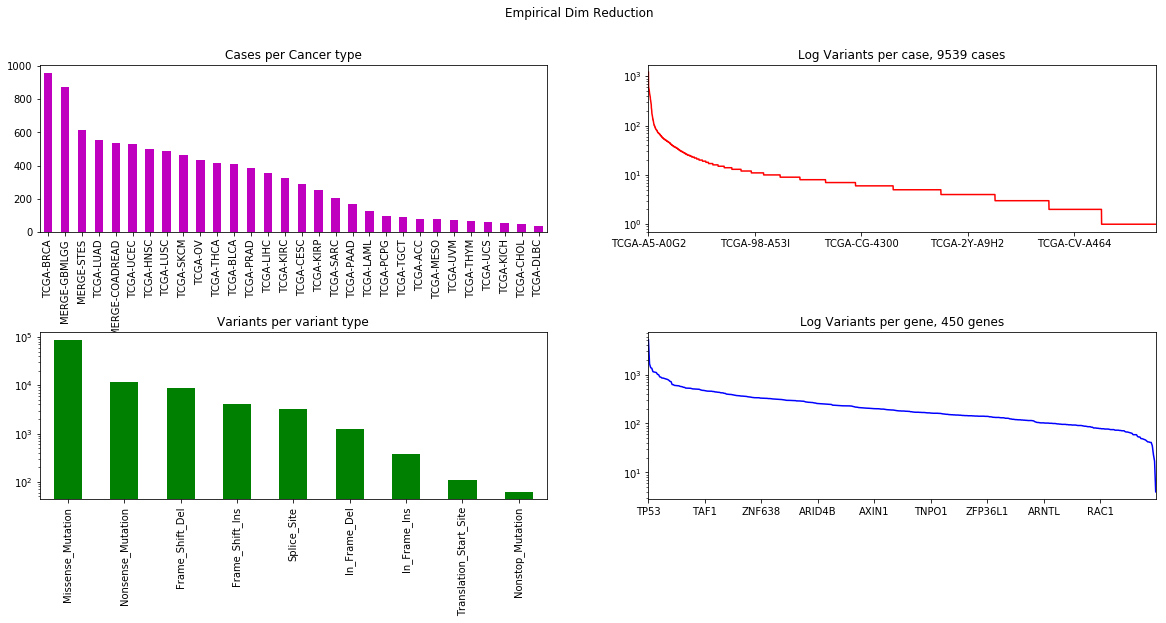

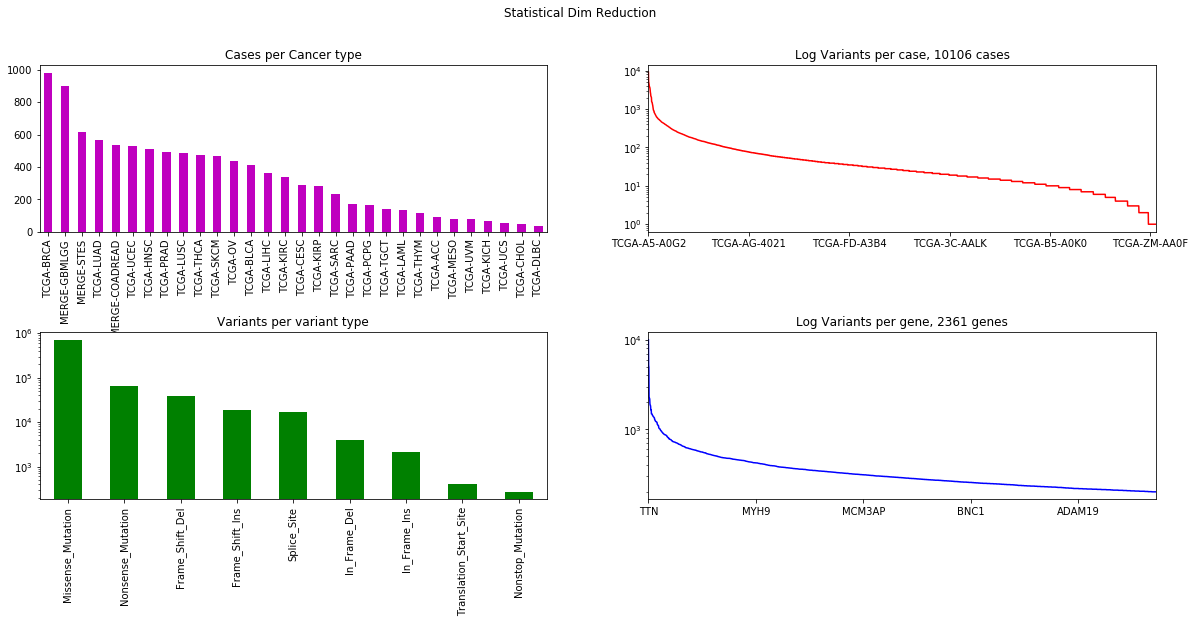

In [11]:
visualise_distributions(df_proc1, 'Empirical Dim Reduction')
visualise_distributions(df_proc2, 'Statistical Dim Reduction')

In [12]:
def dedup_and_get_variant_count(df_in):
    """
    Deduplicate gene sample combinations with >1 mutations and aggregate 
    with additional feature of variant count for gene sample combination.
    """
    df = df_in.copy()
    
    counts = df.groupby('case_barcode')['Hugo_Symbol'].value_counts()
    df = df.drop_duplicates(subset=['case_barcode', 'Hugo_Symbol'])
    df = df.set_index(['case_barcode', 'Hugo_Symbol'])
    df['mutation_count'] = counts
    df = df.reset_index()
    
    return df

def reshape_pivot(df_in):
    """
    Reduce df to crucial subset then pivot on cases and genes.
    """
    df = (df_in[['case_barcode', 'Hugo_Symbol', 'mutation_count']]
              .copy()
              .pivot(index='case_barcode', columns='Hugo_Symbol', values='mutation_count')
              .fillna(0)
              .astype(int))
    
    return df

df_pivot1 = (df_proc1.pipe(dedup_and_get_variant_count)
                     .pipe(reshape_pivot))

df_pivot2 = (df_proc2.pipe(dedup_and_get_variant_count)
                     .pipe(reshape_pivot))

In [13]:
df_pivot1.head()
df_pivot2.head()

Hugo_Symbol,ABL2,ACACA,ACAD8,ACO1,ACSL3,ACSL6,ACTB,ACTG1,ACTG2,ACVR1B,...,YBX1,ZC3H11A,ZFHX3,ZFP36L1,ZFP36L2,ZMYM2,ZNF292,ZNF638,ZNF750,ZNF814
case_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hugo_Symbol,A1CF,A2M,A2ML1,AASDH,AASS,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,...,ZNF845,ZNF91,ZNF98,ZNF99,ZNFX1,ZP4,ZSCAN20,ZSWIM2,ZSWIM8,ZZEF1
case_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
TCGA-02-0047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
#### 6. Produce 2D images for every sample
<a id="2d"></a>

For each sample, now want to encode gene2vec embeddings as a prior on mutation data.

In [50]:
df_pivot1.shape
df_pivot2.shape

def convert_to_onehot(df_in):
    """
    Convert count encoding to one-hot encoded representation of df.
    """
    df = df_in.copy()
    df[df != 0] = 1
    return df

def get_gene_intersection(df1, df2):
    """
    Get intersection of genes (features) from df1 and df2.
    """
    gene_intersection = []
    for gene in df1:
        if gene in df2.columns.tolist():
            gene_intersection.append(gene)

    return gene_intersection

    
def embed_gene_vectors(data_df, gene_df):
    """
    Matrix multiply somatic mutation data by gene embeddings and return batch of images.
    """
    samples = []
    for i, row in data_df.iterrows():
        # multiply gene embedding by bitwise mask taken from sample mutations
        embedded_sample = row.values * gene_df.values
        samples.append(embedded_sample)
    return np.dstack(samples)

def apply_spectral_clustering(data_df, onehot_df, num_clusters=25):
    """
    Determine a sorting on genes which creates visual structure.
    Calculates feature cooccurrence matrix, finds num_clusters as defined and sorts genes accordingly.
    """
    from sklearn.cluster import SpectralClustering
    c_matrix = onehot_df.T.dot(onehot_df) # cooccurrence matrix for genes in data source
    sc = SpectralClustering(num_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(c_matrix)
    return data_df[:,np.argsort(clusters),:]
    
def visualise_sample(sample):
    """
    Visualise sample as image.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pd.DataFrame(sample), aspect='auto')
    # plt.colorbar()

(9539, 450)

(10106, 2361)

In [51]:
test = convert_to_onehot(df_pivot1)
test.values.shape

# load test file
wv, vocabulary = load_embeddings(filename)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocabulary)

genes = get_gene_intersection(test, df_genevec)
merge1 = test[genes]
merge2 = df_genevec[genes]

output = embed_gene_vectors(merge1, merge2)

(9539, 450)

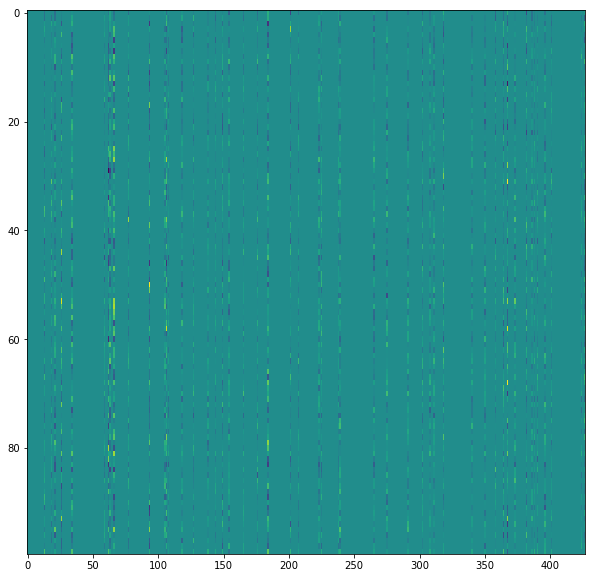

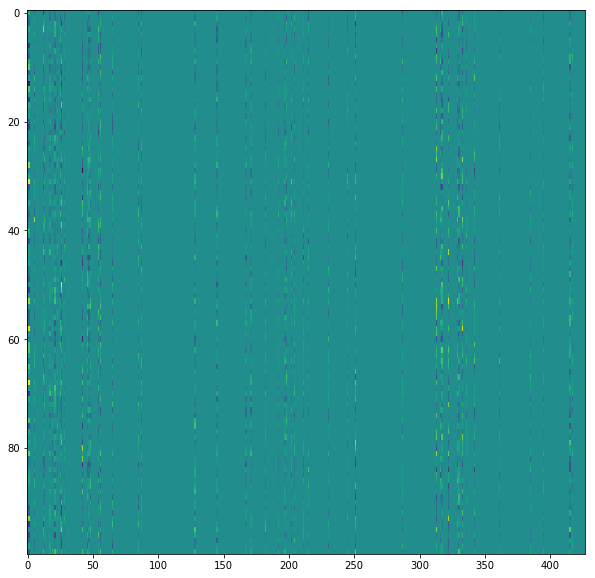

In [52]:
visualise_sample(output[:,:,5000])

clustered = apply_spectral_clustering(output, merge1)
visualise_sample(clustered[:,:,5000])

---

In [53]:
for word in vocabulary:
    if '\n' in word:
        print(word)

NFIB

KAZALD1

RBM39

EFCAB4A

NFIA

PCGF2

RNF111

SETD3

CRK

SCN4A

FAM100A

MEX3B

SPTAN1

FAM190A

IRF2

GPR116

SEC13

DUSP7

IGFBP5

CTTNBP2NL

LSM12

IL2

BMP6

NPNT

SH3D19

SOBP

GCA

CSN3

TRAF4

PTRH2

POFUT1

ODAM

PPP1R13B

FAF1

PRSS27

NHLH1

TOB1

TEX2

MBTPS1

TIAF1

RNF145

KBTBD12

DYM

PERP

FAM134B

KCNN2

GGA1

MGST1

RDH14

RNF40

COMTD1

TMEM151A

IKBKG

VPS26A

CLPB

LOC100130691

TP53INP2

SMPD3

IRF4

SSR2

PAICS

RCN1

SP8

THAP3

GKN1

SP3

PDCD6

C11orf87

RCN2

RNF182

SLC5A7

HTR2C

MPL

TBL1X

LOC440742

FLJ27255

ID3

TBL1Y

FLJ44477

AHCYL1

KIF20B

ARAP3

CUX2

HMBOX1

SH3BGRL2

FAM70A

DKFZP586I1420

SCAND2

TRIT1

MYLPF

IGFBP3

DNAJB6

ATP8A1

GNB2L1

POP5

SLC17A2

HNRNPA2B1

NRAP

HTR2A

NOTUM

CHRNA10

CALM2

SLC18A3

SLC9A1

WDR1

ORAI3

EDC3

FAM96B

LPCAT3

SLC14A2

DR1

SH3BP1

TRPC4AP

F2R

FAM91A1

ZNF219

TOB2

IGFBP4

RMI2

DNM2

TEKT4

DHX57

OPN3

PHF7

CRH

HS3ST3B1

SLC18A1

STEAP1

ABO

CACNA1D

ATP6V0A2

TMEM125

PPP1R7

CALM1

D